# 4. Clean

## Ensure Environment is Configured

**Go [here](01_import_data.ipynb) if you are following along and have not configured the virtual environment and installed dependencies.**

In [1]:
# Jupyter magic
%run ../util/dependencies.py
%load_ext sql

## Define db Interface Methods

In [10]:
# Lets make a simple function to print our queries from the db, using psycopg2 . . .
def vectra_view(my_query):
    # connect to db
    db_connection = psycopg2.connect(dbname = 'vectra',
                                    host='localhost',
                                    user='robb',
                                    password='thek3yisK#')
    cur = db_connection.cursor()

    # return results
    cur.execute(my_query)
    rows = cur.fetchall()
    for row in rows:
        print(row)

    # close
    cur.close()
    db_connection.close()

def vectra_commit(my_query):
    # connect to db
    db_connection = psycopg2.connect(dbname = 'vectra',
                                     host='localhost',
                                     user='robb',
                                     password='thek3yisK#')
    cur = db_connection.cursor()

    # excecute
    cur.execute(my_query)
    db_connection.commit()

    # close
    cur.close()
    db_connection.close()

# Generalized, so should work for any table . . .
def vectra_insert_df(df, table_name, conflict_cols):
    """
    Insert a pandas DataFrame into a PostgreSQL table using psycopg2.
    Handles arbitrary columns and conflict keys.
    """

    # Connect
    conn = psycopg2.connect(
        dbname='vectra',
        host='localhost',
        user='robb',
        password='thek3yisK#'
    )
    cur = conn.cursor()

    # Column list
    cols = list(df.columns)
    col_names = ", ".join(cols)

    # Placeholder for VALUES (%s, %s, %s...)
    placeholders = ", ".join(["%s"] * len(cols))

    # Conflict target
    conflict_target = ", ".join(conflict_cols)

    # Build SET col = EXCLUDED.col for all non-conflict columns
    update_assignments = ", ".join(
        [f"{col} = EXCLUDED.{col}" for col in cols if col not in conflict_cols]
    )

    # Build final SQL
    query = f"""
        INSERT INTO {table_name} ({col_names})
        VALUES %s
        ON CONFLICT ({conflict_target}) DO UPDATE
        SET {update_assignments};
    """

    # Convert DataFrame to list of tuples
    values = [tuple(row) for row in df.to_numpy()]

    # Bulk insert
    execute_values(cur, query, values)

    conn.commit()
    cur.close()
    conn.close()

    print(f"Inserted/updated {len(df)} rows into {table_name}.")


Testing methods here . . .

In [40]:
# Start off simple by checking basic tables . . .
q_table_names = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
"""

q_ata = """
    SELECT * 
    FROM ata_chapter
    ORDER BY ata_chapter
"""

vectra_view(q_ata)

('11', None)
('14', None)
('21', None)
('22', None)
('23', None)
('24', None)
('25', None)
('26', None)
('27', None)
('28', None)
('29', None)
('30', None)
('31', None)
('32', None)
('33', None)
('34', None)
('35', None)
('36', None)
('38', None)
('49', None)
('51', None)
('52', None)
('53', None)
('54', None)
('55', None)
('56', None)
('57', None)
('72', None)
('73', None)
('75', None)
('76', None)
('77', None)
('78', None)
('79', None)
('80', None)


## ATA Chapters
Important to note is that although this entity may not be necessary for analysis of common faulty systems (as we can just derive the ata chapter codes from the JASC), I included this table to allow identifying system (not subsystem) trends with their system names as opposed to just the ATA chapter itself.

**As a personal example from my experience with C-130H's (as ATA Chapters match TO -Technical Order- maintenance documentation), this would help distinguish subsystems -26-10 (fire detection) from -26-20 (fire suppression) wihtin the -26 (fire protection) system.**

An immediate issue that stood out to me was that ATA chapters are not defined in the SDRs (beyond the codes themselves). I can fix this by updating records with the appropriate names based on how the FAA defines each of these chapters.

To do this, I scrapped the ATA chapter definitions from [Aerospace Unlimited](https://www.aerospaceunlimited.com/ata-chapters/) (since this was the cleanest table I could find of these definitions), converted the data to a csv, cleaned the data, sorted, and imported it [here](../data/02_csv/ata_chapters.csv).

Additionally, the new ata chapters are **exhaustive**, this is to say **new ata chapters encountered by the Service Difficulty Reporting System (SDRS) are addressed**.

**Note:**
The following ATA chapters were excluded do to not being included in the JASC codes themselves, as well as not being utilized in the SDRS.
| ATA Chapter | Description |
| --- | --- |
| 115 | Flight Simulator Systems |
| 116 | Flight Simulator Cuing System |
| 72R | Engine - Reciprocating |
| 72T | Engine - Turbine/Turboprop / Ducted Fan/Unducted Fan |

Now lets update the ata_chapter table . . .

In [ ]:
-- verify structure
SELECT *
FROM ata_chapter
LIMIT 10;

In [11]:
# check table right now
import pandas as pd
ata_table = pd.read_csv('../data/02_csv/ata_chapters.csv', index_col=False)
print(ata_table.columns) ## one str and one int type

# lets clean up . . .
ata_table.rename(columns={' Name': 'description', 'Chapter': 'ata_chapter'}, inplace=True) # match entity schema
ata_table['description'] = ata_table['description'].str.strip() # just found out, like excel TRIM()!!
print(ata_table)

vectra_insert_df(ata_table, 'ata_chapter', ['ata_chapter'])

Index(['Chapter', ' Name'], dtype='str')
    ata_chapter                              description
0             0                                  General
1             1                       Maintenance Policy
2             2                               Operations
3             3                                  Support
4             4                Airworthiness Limitations
..          ...                                      ...
80           95                   Crew Escape And Safety
81           96          Missiles - Drones And Telemetry
82           97                         Wiring Reporting
83           98  Meteorological And Atmospheric Research
84           99                Electronic Warfare System

[85 rows x 2 columns]
Inserted/updated 85 rows into ata_chapter.


In [ ]:
-- Verify through native SQL
SELECT *
FROM ata_chapter
ORDER BY ata_chapter ASC;

Getting a weird '14' ata_channel, lets see where this is coming from. I couldn't find it in the [ata_chapters.csv](../data/02_csv/ata_chapters.csv) so it must be from the sdr's themselves?

In [ ]:
vectra_view("""
    SELECT count(*)
    FROM ata_chapter
""")                    # -> 86 total chapters

ata_table.info()        # -> 85 total chapters

(86,)
<class 'pandas.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ata_chapter  85 non-null     int64
 1   description  85 non-null     str  
dtypes: int64(1), str(1)
memory usage: 3.0 KB


Looking over the previous query, '14' has no description, but it IS detailed in the "[FEDERAL AVIATION ADMINISTRATION JOINT AIRCRAFT SYSTEM/COMPONENT CODE TABLE AND DEFINITIONS](https://sdrs.faa.gov/documents/JASC_Code.pdf)" as "Hardware".

In [ ]:
-- Update 14: Hardware
UPDATE ata_chapter
SET description = 'Hardware'
WHERE ata_chapter = 14;

-- Update 85: RECIPROCATING ENGINE
INSERT INTO ata_chapter(ata_chapter, description)
VALUES(85, 'Reciprocating Engine')

SyntaxError: invalid syntax (949731905.py, line 1)

In [ ]:
-- check
SELECT *
FROM ata_chapter
ORDER BY ata_chapter;

## JASC
These codes are critical for identifying subsystems. To map the current JASC codes as well as the entire FAA JASC set (last updated Oct 2008), I scraped the information from the "[FEDERAL AVIATION ADMINISTRATION JOINT AIRCRAFT SYSTEM/COMPONENT CODE TABLE AND DEFINITIONS](https://sdrs.faa.gov/documents/JASC_Code.pdf)" and pasted it into [this text doc](../data/01_raw/jasc_codes_scrapped_from_faa.txt).

In [ ]:
SELECT *
FROM jasc_code
ORDER BY random()
LIMIT 10;

need descriptions again . . .

In [12]:
import math
# Import ../data/01_raw/jasc_codes_scrapped_from_faa.txt as dataframe
# NUMBER[SPACE][DESCRIPTION WITH LOTS OF COMMAS AND OTHER ANNOYING PUNCTUATION]

#open the file
with open('../data/01_raw/jasc_codes_scrapped_from_faa.txt') as f:
    lines = f.readlines()

jasc_table = pd.DataFrame(columns=['jasc_code', 'ata_chapter', 'description']) # string, int, text
jasc_table['jasc_code'] = jasc_table['jasc_code'].astype(int)
jasc_table['ata_chapter'] = jasc_table['ata_chapter'].astype(int)

for line in lines:
    code, desc = line.split(sep=' ', maxsplit=1)
    if(len(code.strip()) == 4):
        jasc_table.loc[len(jasc_table)] = [code, code[:2], desc] # take first two digits of jasc

jasc_table #yay!!

,jasc_code,ata_chapter,description
0,1100,11,PLACARDS AND MARKINGS\n
1,1210,12,FUEL SERVICING\n
2,1220,12,OIL SERVICING\n
3,1230,12,HYDRAULIC FLUID SERVICING\n
4,1240,12,COOLANT SERVICING\n
...,...,...,...
542,8540,85,RECIPROCATING ENGINE REAR SECTION\n
543,8550,85,RECIPROCATING ENGINE OIL SYSTEM\n
544,8560,85,RECIPROCATING ENGINE SUPERCHARGER\n
545,8570,85,RECIPROCATING ENGINE LIQUID COOLING\n


After further consideration this is more exhaustive than what we have in the jasc_code entity already. As such, I'll adjust the imported JASCs from the SDRs and replace them here...

In [13]:
vectra_insert_df(df=jasc_table, table_name='jasc_code', conflict_cols=['jasc_code'])

Inserted/updated 547 rows into jasc_code.


In [ ]:
--check
SELECT *
FROM jasc_code
ORDER BY jasc_code;

## Operator

In [14]:
SELECT count(*)
FROM operator; --only 12

SELECT column_name, data_type, is_nullable
FROM information_schema.columns
WHERE table_name = 'operator'; --i'll pick 'designator' to order by

SELECT designator, name
FROM operator
ORDER BY designator; --uh oh, 4 letter designations


SyntaxError: unterminated string literal (detected at line 6) (3998312195.py, line 6)

there is no public FAA table of 4‑letter SDR operator prefixes.  
And that’s exactly why you couldn’t find one.

Let me explain clearly, because this is one of the FAA’s weirdest quirks and it trips up everyone who works with SDRs for the first time.
Why there is no 4‑letter designator table

Because the 4‑letter codes in SDRs are not official operator designators at all.

They are Operator Control Number prefixes, and the FAA does not publish a master list of them.

These prefixes exist only inside the SDR system, and they are generated internally for the purpose of creating unique SDR IDs.

The Service Difficulty Reporting System (SDRS) predates the FAA use of the three letter designator 

In [ ]:
-- Adjust designator title for accuracy
ALTER TABLE operator
RENAME COLUMN designator TO sdr_prefix;

-- add faa_designator (3 letter)
ALTER TABLE operator
ADD COLUMN faa_designator varchar(3) UNIQUE;

In [ ]:
-- ===============
-- Don't judge me
-- ===============
UPDATE operator
SET name = 'Southwest Airlines', faa_designator = 'SWA'
WHERE sdr_prefix = 'SWAA';

UPDATE operator
SET name = 'Delta Air Lines', faa_designator = 'DAL'
WHERE sdr_prefix = 'DALA';

UPDATE operator
SET name = 'American Airlines', faa_designator = 'AAL'
WHERE sdr_prefix = 'AALA';

UPDATE operator
SET name = 'Alaska Airlines (Horizon/Alaska)', faa_designator = 'ASA'
WHERE sdr_prefix = 'ASAA';

UPDATE operator
SET name = 'Sun Country Airlines', faa_designator = 'SCX'
WHERE sdr_prefix = 'SCNA';

UPDATE operator
SET name = 'Beijing Airlines CO. LTD', faa_designator = 'BJN'
WHERE sdr_prefix = 'BJNA';

UPDATE operator
SET name = 'Ameriflight', faa_designator = 'AMF'
WHERE sdr_prefix = 'ASMF';

In [ ]:
--check
SELECT *
FROM operator
ORDER BY sdr_prefix;

We can adjust this by including the entire operator designator list provided by the FAA [here](../data/01_raw/Three−Letter%20Designator_Aircraft%20Company_Telephony%20Decode.html).

In [15]:
tables = pd.read_html(io='../data/01_raw/Three−Letter Designator_Aircraft Company_Telephony Decode.html')
len(tables) # -> 26 tables (one for each letter)

des_table = pd.DataFrame(columns=['sdr_prefix', 'faa_designator', 'name'])

# append all records from all tables to des_table
# (definitely better ways of doing this, this is slow!!! 52 seconds!!!)
# for table in tables:
#     for row in table.itertuples(index=False):
#         des_table.loc[len(des_table)] = [row[0], row[1]]

#SO MUCH FASTER (0.2 sec)!!!
des_table = pd.concat(tables, ignore_index=True)
des_table.drop(columns=['Country', 'Telephony'], inplace=True)
des_table.rename(columns={'3Ltr':'faa_designator', 'Company':'name'}, inplace=True)

des_table
    

,faa_designator,name
0,AAA,AVICON AVIATION CONSULTANTS & AGENTS
1,AAB,ABELAG AVIATION
2,AAC,ARMY AIR CORPS
3,AAD,ARRENDAMIENTOS AEREOS
4,AAE,AIR ATLANTA EUROPE
...,...,...
6201,ZTZ,AERODROME CONTROL TOWER
6202,ZUZ,UPPER AREA CONTROL CENTRE
6203,ZYZ,AERODROME SECURITY SERVICES
6204,ZZM,AGENCE NATIONALE DES AERODROMES ET DE LA METEO...


Add to the database . . .

In [ ]:
ALTER TABLE operator
ALTER COLUMN sdr_prefix DROP NOT NULL;

ALTER TABLE operator
ALTER COLUMN name TYPE varchar (300);

In [16]:
des_table['sdr_prefix'] = None
des_table[des_table.duplicated(subset='faa_designator')] # duplicate for SZL -> ROYAL ESTWATINI NATIONAL AIRWAYS CORPORATION

# drop duplicate
des_table = des_table[~des_table.duplicated(subset='faa_designator', keep='last')]

des_table[des_table.duplicated(subset='faa_designator')]
des_table
# looks good!

,faa_designator,name,sdr_prefix
0,AAA,AVICON AVIATION CONSULTANTS & AGENTS,None
1,AAB,ABELAG AVIATION,None
2,AAC,ARMY AIR CORPS,None
3,AAD,ARRENDAMIENTOS AEREOS,None
4,AAE,AIR ATLANTA EUROPE,None
...,...,...,...
6201,ZTZ,AERODROME CONTROL TOWER,None
6202,ZUZ,UPPER AREA CONTROL CENTRE,None
6203,ZYZ,AERODROME SECURITY SERVICES,None
6204,ZZM,AGENCE NATIONALE DES AERODROMES ET DE LA METEO...,None


In [17]:
vectra_insert_df(df=des_table, table_name='operator', conflict_cols=['faa_designator'])

Inserted/updated 6205 rows into operator.


In [ ]:
--check
SELECT *
FROM operator
ORDER BY sdr_prefix;

In [ ]:
-- =========================================
-- Update tables with overwritten sdr_prefix
-- =========================================
UPDATE operator
SET sdr_prefix = 'SWAA'
WHERE faa_designator = 'SWA';

UPDATE operator
SET sdr_prefix = 'DALA'
WHERE faa_designator = 'DAL';

UPDATE operator
SET sdr_prefix = 'AALA'
WHERE faa_designator = 'AAL';

UPDATE operator
SET sdr_prefix = 'ASAA'
WHERE faa_designator = 'ASA';

UPDATE operator
SET sdr_prefix = 'SCNA'
WHERE faa_designator = 'SCX';

UPDATE operator
SET sdr_prefix = 'BJNA'
WHERE faa_designator = 'BJN';

UPDATE operator
SET sdr_prefix = 'ASMF'
WHERE faa_designator = 'AMF';

### Determining undefined sdr_prefixs
Some sdr_prefixes are still not defined...
| sdr_prefix | name |
| --- | --- |
| 4TXA | ? |
| AALA | ? |
| CALA | ? |
| K11A | ? |
| UIEA | ? |
| WX0A | ? |

We can address this like crytography and solving the Ceasar's Cypher... where are the most common discrepancies found in our SDR? We can use this as a proxy for fleet size and # of flights.

In [ ]:
SELECT op.sdr_prefix, op.name, count(op.sdr_prefix) AS discrepancies
FROM sdr_event AS sdr
INNER JOIN operator AS op
    ON sdr.operator_id = op.id
GROUP BY op.sdr_prefix, op.name
ORDER BY discrepancies DESC;

The Boeing 737-800 is a widely used narrowbody aircraft with over 4,500 in operation globally. Major U.S. operators include American Airlines (~303), Southwest Airlines (~200+), United Airlines (~141), and Delta Air Lines (77).

Thus, we can confidently say that we should map our sdr_prefixs as follows:
| sdr_prefix | name | aligns with insights? |
| --- | --- | --- |
| AALA | American Airlines | Yes |
| SWAA | Southwest Airlines | Yes |
| CALA | ? | United, Suspect |
| DALA | Delta | Yes |
| ASAA | Alaska | ? |
| SCNA | Sun Country | ? |
| UIEA | ? | ? |
| WX0A | ? | ? |
| K11A | ? | ? |
| 4TXA | ? | ? |

Lets research if CALA is united firist since that is where a large sum of the discrepancies and information are found.

SDR operator prefixes are internal FAA identifiers that often resemble real FAA/ICAO codes but do not reliably map to them, which means they must be interpreted through data patterns rather than literal code matching. In this project, the distribution of SDR reports aligns cleanly with known 737‑800 fleet sizes: AALA (American), SWAA (Southwest), DALA (Delta), ASAA (Alaska), and SCNA (Sun Country). The remaining high‑volume prefix, CALA, cannot represent China Airlines—who neither operate 737‑800s nor submit U.S. SDRs—and instead matches United Airlines based on its SDR frequency and fleet size. Thus, operator mapping is inferred through operational patterns, not code similarity, which is standard practice when working with FAA SDR data.

In [ ]:
-- Find UNITED matches in data
SELECT faa_designator, sdr_prefix, name
FROM operator
WHERE sdr_prefix = 'CALA' OR name LIKE '%UNITED%'

In [ ]:
-- temp adjust operator to not be unique
ALTER TABLE operator
DROP CONSTRAINT operator_faa_designator_key;

-- United airlines match as 'UCB'
UPDATE operator
SET faa_designator = 'UCB', name = 'UNITED AIRLINES, INC. (CHICAGO, IL)'
WHERE sdr_prefix = 'CALA';

DELETE FROM operator
WHERE faa_designator = 'UCB' AND sdr_prefix IS NULL;

-- Reapply unique contstraint
ALTER TABLE operator
ADD CONSTRAINT operator_faa_designator_key UNIQUE (faa_designator);

In [ ]:
-- check
SELECT faa_designator, sdr_prefix, name
FROM operator
WHERE sdr_prefix = 'CALA' OR name LIKE '%UNITED%'

## Aircraft
Lets get a brief overview of the data . . .

In [ ]:
SELECT model, count(model)
FROM aircraft
GROUP BY model
ORDER BY count(model) DESC;

“The FAA SDR dataset includes airline‑specific Boeing customer codes (e.g., 737‑823, 737‑8H4), which represent configuration differences for individual operators but do not indicate major structural or systems differences. For reliability analysis, these sub‑variants were normalized to the base model 737‑800, with optional grouping by operator to capture maintenance‑culture‑driven patterns.”

Lets dig into how clean our data is . . .

In [ ]:
-- Check columns
SELECT * 
FROM aircraft
LIMIT 10;

-- registry_n_number
SELECT count(registry_n_number)
FROM aircraft
WHERE registry_n_number IS NULL
    OR TRIM(registry_n_number) = '';

-- make
SELECT count(make)
FROM aircraft
WHERE make IS NULL
    OR TRIM(make) = '';

-- model
SELECT count(model)
FROM aircraft
WHERE model IS NULL
    OR TRIM(model) = '';

-- serial_number
SELECT count(serial_number)
FROM aircraft
WHERE serial_number IS NULL
    OR TRIM(serial_number) = '';

-- total_time
SELECT count(total_time)
FROM aircraft
WHERE total_time IS NULL
    OR total_time = 0;

-- total_cycles
SELECT count(total_cycles)
FROM aircraft
WHERE total_cycles IS NULL
    OR total_cycles = 0;

Looks good!

## sdr_event
This is the behemouth . . .

In [ ]:
-- Entity overview
SELECT *
FROM sdr_event
LIMIT 10;

Overview of null and incomplete data through python . . .

In [2]:
import psycopg2

# open connection
vectra_connection = psycopg2.connect(database='vectra',
                host='localhost',
                user='robb',
                password='thek3yisK#')
cur = vectra_connection.cursor()

# fetch records of sdr_event
cur.execute("""
            SELECT *
            FROM sdr_event;
            """)
records = cur.fetchall()

# fetch column names
col_names = [desc[0] for desc in cur.description]

#build table
df_sdr_event_table = pd.DataFrame(data=records, columns=col_names)

# close connection
cur.close()
vectra_connection.close()
    


In [3]:
print(df_sdr_event_table.head())
print(df_sdr_event_table.info())
print(df_sdr_event_table.describe())

   id operator_control_number difficulty_date submission_date  \
0   1       CALA2025072106747      2025-07-17      2025-07-21   
1   2       SWAA2025072193261      2025-07-19      2025-07-21   
2   3       SWAA2025082792733      2025-07-18      2025-08-27   
3   4        AALA202508285422      2025-07-11      2025-08-28   
4   5       SWAA2025082794271      2025-07-22      2025-08-27   

   operator_designator_id  submitter_designator_id submitter_type_code  \
0                     7.0                      7.0                   A   
1                    10.0                     10.0                   A   
2                    10.0                     10.0                   A   
3                     6.0                      6.0                   A   
4                    10.0                     10.0                   A   

  receiving_region_code receiving_district_office sdr_type  ...  \
0                    GL                        33        A  ...   
1                    SW       

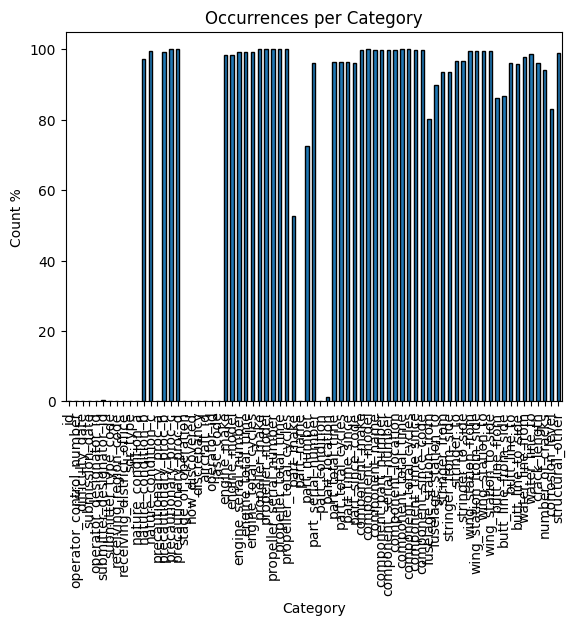

In [ ]:
import matplotlib.pyplot as plt

# Null count
s_nulls = df_sdr_event_table.isnull().sum()

# Normalize
s_nulls_pct = (s_nulls / len(df_sdr_event_table)) * 100

# plot
s_nulls_pct.plot(kind='bar', edgecolor='black')
plt.xlabel("Category")
plt.ylabel("Count %")
plt.title("NULLS per Category")
plt.show()
